# Ukranian Audio Digits Recognition

## Environment Setup

In [1]:
from colabcode import ColabCode

In [2]:
%%writefile requirements.txt

torch #pytorch
torchvision
matplotlib
numpy
tqdm
pandas
opencv-python #cv2
albumentations
python-magic
pydub
torchmetrics
librosa
torchaudio-augmentations

Overwriting requirements.txt


In [3]:
!pip install -r requirements.txt >> /dev/null

## Imports

In [30]:
import os
import csv
import tqdm
import torch
import torchaudio
import numpy as np
import torchvision
import torchmetrics
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from misc.constants import CONST
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

## Project misc functions

In [5]:
def count_paths(paths):
    count_woman = sum('woman' in path.lower() for path in paths)
    count_man = sum('man' in path.lower() and 'woman' not in path.lower() for path in paths)

    return count_woman, count_man

## Project Setup

In [6]:
initializer = Initializer("dataset")
initializer.initialize_project()

## Simple Data Analys

Our dataset contain recordings of digits from `0` to `1`. We implement this dataset by ourselves. In total we have 100 different men women voices with different age starting from `10` ending `60`. However the median and mode is about `20` years old. 

In [7]:
df = pd.read_csv(CONST.CSV_PATH)

print("Total amount of recordings: ", len(df))

Total amount of recordings:  4395


In [8]:
df.head()

,file_path,label
0,/home/nickolay/ML/ukranian-spoken-digits/datas...,6
1,/home/nickolay/ML/ukranian-spoken-digits/datas...,2
2,/home/nickolay/ML/ukranian-spoken-digits/datas...,4
3,/home/nickolay/ML/ukranian-spoken-digits/datas...,8
4,/home/nickolay/ML/ukranian-spoken-digits/datas...,3


In [9]:
count_woman, count_man = count_paths(df['file_path'].tolist())

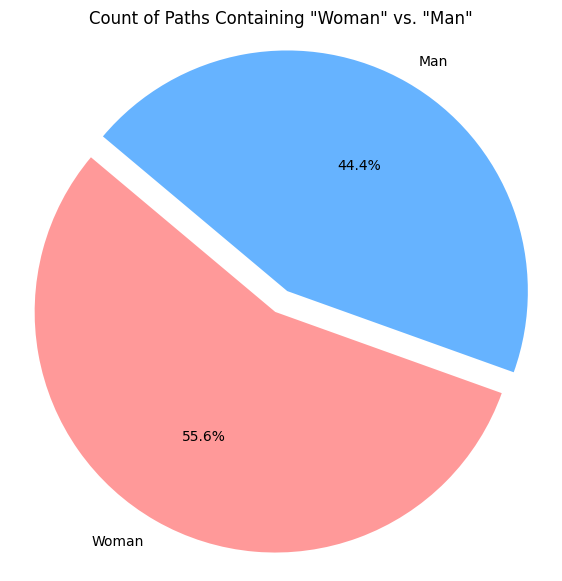

In [10]:
labels = ['Woman', 'Man']
sizes = [count_woman, count_man]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  
plt.figure(figsize=(7,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Count of Paths Containing "Woman" vs. "Man"')
plt.show()

## Data Processing

In [11]:
df_subset = df.head(15)

mfcc_features = []
for file_path in df_subset['file_path']:
    audio, sample_rate = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13)
    mfccs_mean = np.mean(mfccs, axis=1)
    mfcc_features.append(mfccs_mean)

df_subset['MFCC'] = mfcc_features

/tmp/ipykernel_336774/3665164361.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['MFCC'] = mfcc_features


### Visualize MFCC

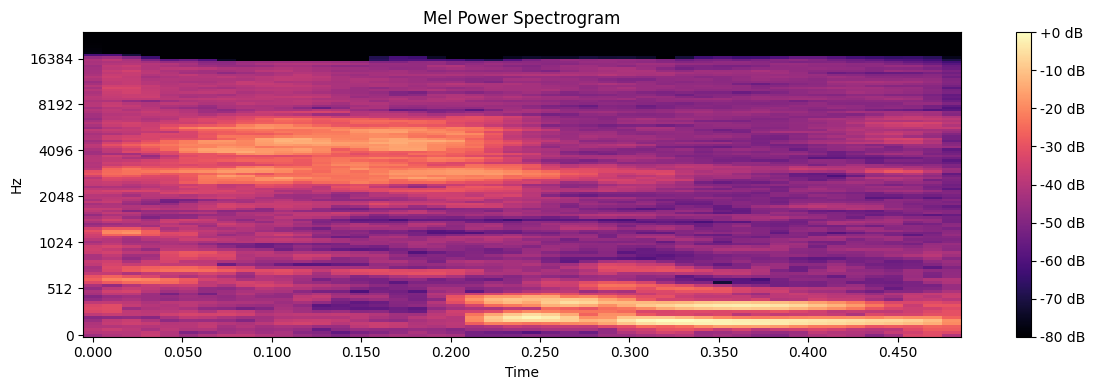

In [12]:
file_path = df_subset['file_path'].iloc[0]
audio, sample_rate = librosa.load(file_path, sr=None)

S = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_mels=128)

log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))

librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')

plt.title('Mel Power Spectrogram')

plt.colorbar(format='%+02.0f dB')

plt.tight_layout()
plt.show()

In [13]:
from lfcc import lfcc

lfcc_features = []
for file_path in df_subset['file_path']:
    audio, sample_rate = librosa.load(file_path, sr=None)
    lfccs = lfcc(y=audio, sr=sample_rate)
    lfcc_features.append(lfccs)


df_subset['LFCC'] = lfcc_features

/tmp/ipykernel_336774/16997014.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['LFCC'] = lfcc_features


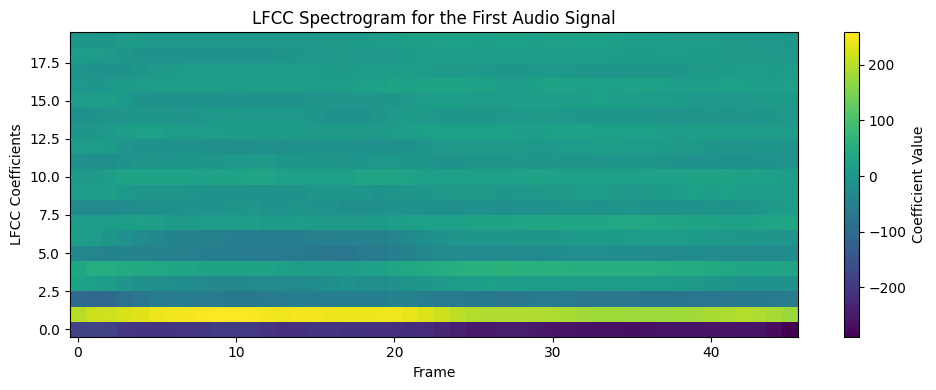

In [14]:
first_lfcc_features = lfcc_features[0]
plt.figure(figsize=(10, 4))
plt.imshow(first_lfcc_features, aspect='auto', origin='lower', cmap='viridis')
plt.title('LFCC Spectrogram for the First Audio Signal')
plt.ylabel('LFCC Coefficients')
plt.xlabel('Frame')
plt.colorbar(label='Coefficient Value')
plt.tight_layout()
plt.show()

## CQCC Implementation and saving according to audio file

In [15]:
from scipy.interpolate import interp1d
def extract_CQCC(file_path, n_bins=96, fmin=None, fmax=None, n_ceps=13):
    audio_path = file_path
    y, sr = librosa.load(audio_path)
    if fmin is None:
        fmin = librosa.note_to_hz('C1')
    # Ensure maximum frequency is set, default to Nyquist
    if fmax is None:
        fmax = sr / 2
    CQT = np.abs(librosa.cqt(y, sr=sr, fmin=fmin, n_bins=n_bins, bins_per_octave=n_bins//8, hop_length=512))
    log_CQT = np.log(CQT**2 + np.finfo(float).eps)
    freqs = librosa.cqt_frequencies(n_bins, fmin = fmin, bins_per_octave=n_bins//8)
    target_freqs = np.linspace(freqs[0], freqs[-1], num=log_CQT.shape[0])
    resampled_log_CQT = np.zeros_like(log_CQT)
    for i in range(log_CQT.shape[1]):
        interp_func = interp1d(freqs, log_CQT[:, i])
        resampled_log_CQT[:, i] = interp_func(target_freqs)

    cqcc = dct(resampled_log_CQT, type=2, axis=0, norm='ortho')[:n_ceps, :]

    return cqcc

cqcc_features = []
for file_path in df_subset['file_path']:
    cqcc = extract_CQCC(file_path)
    cqcc_features.append(cqcc)

df_subset['CQCC'] = cqcc_features

/home/nickolay/ML/ukranian-spoken-digits/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=128 is too large for input signal of length=83
  warnings.warn(
/home/nickolay/ML/ukranian-spoken-digits/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=128 is too large for input signal of length=72
  warnings.warn(
/home/nickolay/ML/ukranian-spoken-digits/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=128 is too large for input signal of length=84
  warnings.warn(
/home/nickolay/ML/ukranian-spoken-digits/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=128 is too large for input signal of length=94
  warnings.warn(
/home/nickolay/ML/ukranian-spoken-digits/venv/lib/python3.11/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=128 is too large for input signal of length=108
  warnings.warn(
/home/nickolay/ML/ukranian-spoken-digits/venv/lib/python3.1

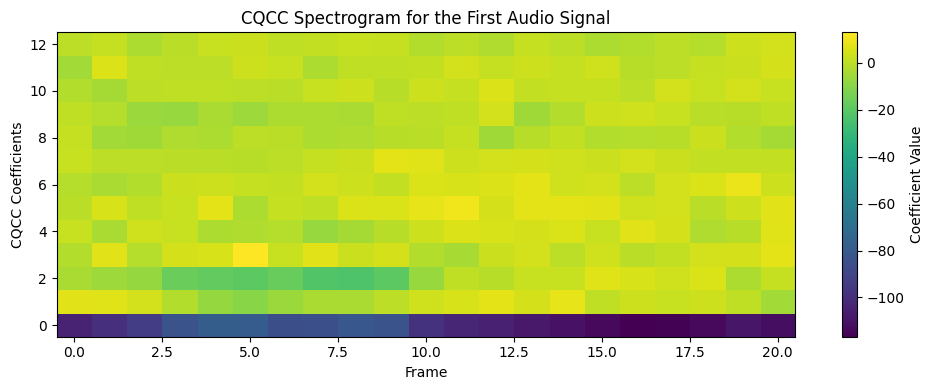

In [16]:
first_cqcc_features = cqcc_features[0]
plt.figure(figsize=(10, 4))
plt.imshow(first_cqcc_features, aspect='auto', origin='lower', cmap='viridis')
plt.title('CQCC Spectrogram for the First Audio Signal')
plt.ylabel('CQCC Coefficients')
plt.xlabel('Frame')
plt.colorbar(label='Coefficient Value')
plt.tight_layout()
plt.show()

In [17]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import torchaudio
from torchaudio_augmentations import *
import torchaudio.transforms as T

class AudioDataset(Dataset):
    def __init__(self, data: pd.DataFrame, transforms=True):
        self.data = data
        self.transforms = transforms
        self.mfcc_transform = T.MFCC(
            sample_rate=16000,    # You may need to adjust this depending on your data
            n_mfcc=13,
            melkwargs={'n_fft': 2048, 'hop_length': 512, 'n_mels': 40}  # n_mels is adjustable
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        path = item['file_path']
        audio, sr = torchaudio.load(path)
        mfcc = self.mfcc_transform(audio)  # Ensure waveform is (channels, time)
        mfcc = mfcc.squeeze(0).float()  # Adjust dimensions and data type as needed
        label = torch.tensor(item['label']).long()
        return mfcc, label
        

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Ensure there's a channel dimension
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [19]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, train_size=0.8)
train_df, valid_df = train_test_split(train_df, train_size=0.8)

In [20]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
params = {
    "epochs": 50,
    "lr": 0.001,
    "batch_size": 16,
    "device": device,
    "classes": 10,
}

In [23]:
import torch.optim as optim
import torch.nn as nn
model = CNN(10).to(device)
criterion = nn.BCEWithLogitsLoss().to(params['device'])
optimizer = optim.Adam(model.parameters(), lr=params['lr'])

In [24]:
def pad_collate(batch):
    data, labels = zip(*batch)    
    max_length = max(x.shape[1] for x in data)  
    padded_data = [torch.nn.functional.pad(x, (0, max_length - x.shape[1])) for x in data] 
    
    data_tensor = torch.stack(padded_data)
    labels_tensor = torch.tensor(labels)
    
    return data_tensor, labels_tensor

In [25]:
from torch.utils.data import Dataset, DataLoader
train_dataset = AudioDataset(train_df)
test_dataset = AudioDataset(test_df, True)
test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], collate_fn=pad_collate)
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], collate_fn=pad_collate)
valid_loader = DataLoader(AudioDataset(valid_df), batch_size=params['batch_size'], collate_fn=pad_collate)

In [26]:
import torchmetrics

def setup_metrics(device, num_classes):
    acc = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes).to(device)
    prec = torchmetrics.Precision(task="multiclass", num_classes=num_classes, average='macro').to(device)
    recall = torchmetrics.Recall(task="multiclass", num_classes=num_classes, average='macro').to(device)
    f1 = torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='macro').to(device)
    return acc, prec, recall, f1


In [27]:
train_loss = []
val_loss = []
accuracies = []
precisions = []
recalls = []
f1_scores = []

  0%|          | 0/1 [00:00<?, ?it/s]

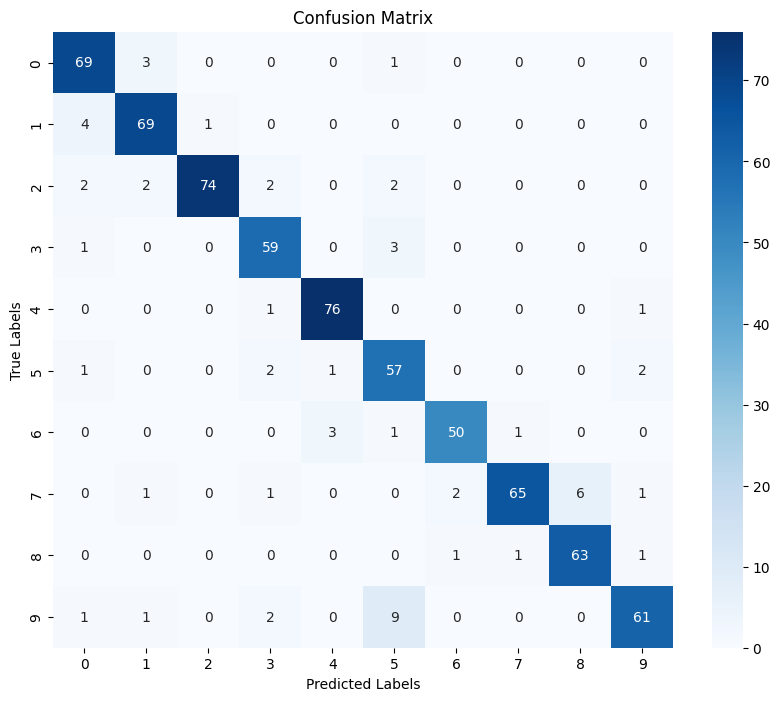

100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


In [31]:
for epoch in tqdm.trange(1):
    model.train()
    total_val_loss = 0
    total_train_loss = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    train_loss.append(total_train_loss / len(train_loader))

    model.eval()
    acc, prec, recall, f1 = setup_metrics(device, 10)
    all_targets, all_preds = [], []

    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = torch.nn.functional.cross_entropy(output, target)
            acc(output, target)
            prec(output, target)
            recall(output, target)
            f1(output, target)
            total_val_loss += loss.item()

            # Store predictions and targets for confusion matrix
            _, predicted_labels = torch.max(output, 1)
            all_preds.extend(predicted_labels.view(-1).cpu().numpy())
            all_targets.extend(target.view(-1).cpu().numpy())

        accuracies.append(acc.compute())
        precisions.append(prec.compute())
        recalls.append(recall.compute())
        f1_scores.append(f1.compute())
        val_loss.append(total_val_loss / len(valid_loader))

        # Compute confusion matrix
        cm = confusion_matrix(all_targets, all_preds, labels=np.arange(10))

        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title('Confusion Matrix')
        plt.show()

100 100


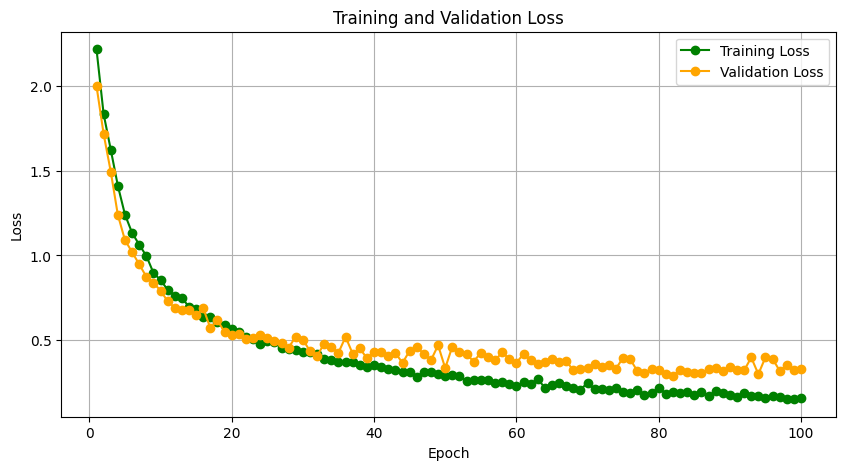

In [29]:
epochs = list(range(1, 101))
print(len(val_loss), len(train_loss))
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, marker='o', label='Training Loss', color="green")
plt.plot(epochs, val_loss, marker='o', label='Validation Loss', color="orange")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()

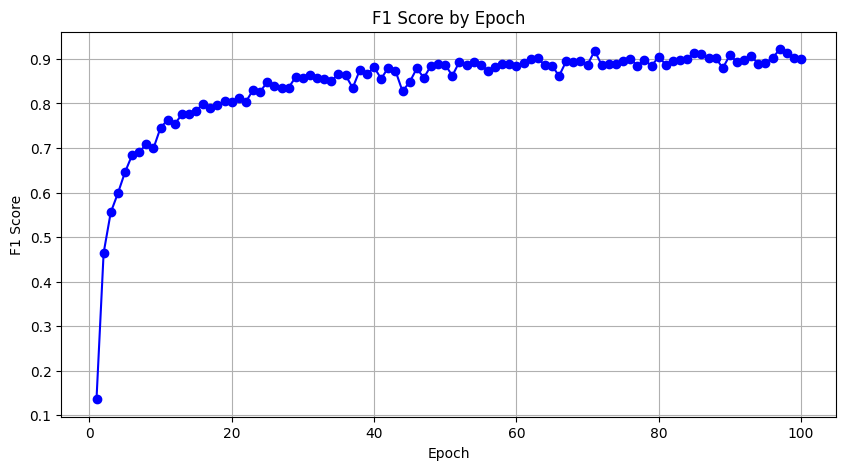

In [30]:
accuracies_t = [float(x.cpu()) for x in accuracies] 
f1_t = [float(x.cpu()) for x in f1_scores]
precisions_t = [float(x.cpu()) for x in precisions]
recalls_t = [float(x.cpu()) for x in recalls]
plt.figure(figsize=(10, 5))
plt.plot(epochs, precisions_t, marker='o', linestyle='-', color='blue')
plt.title('F1 Score by Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [31]:
torch.save(model, "model.pth")